In [10]:
import pandas as pd
import numpy as np
import datetime

data_file = '../fxdata/EURUSD-2019-02.csv'

df = pd.read_csv(data_file, header=None)

df[1] = pd.to_datetime(df[1], format='%Y%m%d %H:%M:%S.%f')

df.head()

,0,1,2,3
0,EUR/USD,2019-02-01 00:00:00.334,1.14480,1.14485
1,EUR/USD,2019-02-01 00:00:00.414,1.14479,1.14485
2,EUR/USD,2019-02-01 00:00:00.535,1.14479,1.14481
3,EUR/USD,2019-02-01 00:00:00.546,1.14478,1.14482
4,EUR/USD,2019-02-01 00:00:00.605,1.14478,1.14480


In [18]:
base_date = datetime.datetime.strptime('2019-02-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.datetime.strptime('2019-03-01 00:00:00', '%Y-%m-%d %H:%M:%S')
date_increment = datetime.timedelta(hours=1)
current_date = base_date
hourly_df = []
while current_date < end_date:
    current_frame = { 'date': current_date }
    tickdata = df[(df[1] >= current_date) & (df[1] < (current_date + date_increment)) ][2]
    if tickdata.shape[0] == 0:
        current_date = current_date + date_increment
        continue
    current_frame['open'] = tickdata.iloc[0]
    current_frame['close'] = tickdata.iloc[-1]
    current_frame['high'] = tickdata.max()
    current_frame['low'] = tickdata.min()
    current_date = current_date + date_increment
    hourly_df.append(current_frame)
    
df = pd.DataFrame(hourly_df)

df.head()

,close,date,high,low,open
0,1.14482,2019-02-01 00:00:00,1.14499,1.14461,1.14480
1,1.14424,2019-02-01 01:00:00,1.14488,1.14376,1.14481
2,1.14426,2019-02-01 02:00:00,1.14431,1.14378,1.14424
3,1.14420,2019-02-01 03:00:00,1.14473,1.14404,1.14426
4,1.14419,2019-02-01 04:00:00,1.14435,1.14381,1.14419


In [20]:
# from here on it should look familiar
import pandas as pd
import numpy as np
import lightgbm as lg

# first let us create some fake price data
#n=10000
price_close = df['close']
price_open = df['open']
price_high = df['high']
price_low = df['low']

# the target is the next close price, lets construct some features - this is usually referred to as feature engineering
features = []
feature_length = 100
targets = price_close[feature_length:]
for i in range(feature_length, price_open.shape[0]):
    feature_object = dict()
    feature_object['MA'] = np.mean(price_open[(i-feature_length):i])
    feature_object['STD'] = np.std(price_open[(i-feature_length):i])
    feature_object['MIN'] = np.min(price_open[(i-feature_length):i])
    feature_object['MAX'] = np.max(price_open[(i-feature_length):i])
    features.append(feature_object)
df = pd.DataFrame(features)

In [21]:
import matplotlib.pyplot as plt 

plt.plot(price_close)

#plt.xlabel('')
#plt.ylabel('voltage (mV)')
#plt.title('About as simple as it gets, folks')
#plt.grid(True)
plt.savefig("test.png")
plt.show()

<Figure size 640x480 with 1 Axes>

In [23]:
# now let us create a data set and a test set
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(df, targets, test_size = 0.30)

d_train = lg.Dataset(x_train, y_train)
d_valid = lg.Dataset(x_valid, y_valid)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression'
}

estimator = lg.train(params, d_train, 1000, [d_valid])

[1]	valid_0's l2: 1.07844e-05
[2]	valid_0's l2: 9.1661e-06
[3]	valid_0's l2: 7.86407e-06
[4]	valid_0's l2: 6.78762e-06
[5]	valid_0's l2: 5.89068e-06
[6]	valid_0's l2: 5.02441e-06
[7]	valid_0's l2: 4.32271e-06
[8]	valid_0's l2: 3.75525e-06
[9]	valid_0's l2: 3.29411e-06
[10]	valid_0's l2: 2.924e-06
[11]	valid_0's l2: 2.62663e-06
[12]	valid_0's l2: 2.38548e-06
[13]	valid_0's l2: 2.19426e-06
[14]	valid_0's l2: 1.99879e-06
[15]	valid_0's l2: 1.84029e-06
[16]	valid_0's l2: 1.71271e-06
[17]	valid_0's l2: 1.6111e-06
[18]	valid_0's l2: 1.53381e-06
[19]	valid_0's l2: 1.46901e-06
[20]	valid_0's l2: 1.42024e-06
[21]	valid_0's l2: 1.37553e-06
[22]	valid_0's l2: 1.33284e-06
[23]	valid_0's l2: 1.29694e-06
[24]	valid_0's l2: 1.26803e-06
[25]	valid_0's l2: 1.24284e-06
[26]	valid_0's l2: 1.20607e-06
[27]	valid_0's l2: 1.19211e-06
[28]	valid_0's l2: 1.17332e-06
[29]	valid_0's l2: 1.1583e-06
[30]	valid_0's l2: 1.14877e-06
[31]	valid_0's l2: 1.1448e-06
[32]	valid_0's l2: 1.12403e-06
[33]	valid_0's l2: 1.11

In [24]:
mse = np.sqrt(np.mean( (estimator.predict(x_valid) - y_valid)**2))
mean_relative_error = mse / np.mean(price_close)
print('Mean relative error ' + str(mean_relative_error))

Mean relative error 0.0007461962614319215


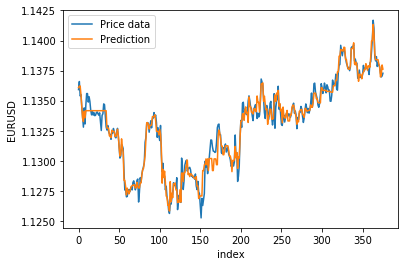

In [39]:
targets_prediction = estimator.predict(df)

import matplotlib.pyplot as plt 

plt.plot(targets.values, label='Price data')
plt.plot(targets_prediction, label='Prediction')
plt.legend(loc='upper left')

plt.xlabel('index')
plt.ylabel('EURUSD')

plt.savefig("compare.png")
plt.show()

100    1.13593
101    1.13660
102    1.13541
103    1.13552
104    1.13449
105    1.13363
106    1.13281
107    1.13441
108    1.13307
109    1.13466
110    1.13560
111    1.13560
112    1.13489
113    1.13534
114    1.13494
115    1.13423
116    1.13383
117    1.13418
118    1.13381
119    1.13401
120    1.13376
121    1.13380
122    1.13403
123    1.13408
124    1.13391
125    1.13380
126    1.13400
127    1.13322
128    1.13253
129    1.13379
        ...   
446    1.13755
447    1.13693
448    1.13710
449    1.13690
450    1.13720
451    1.13794
452    1.13747
453    1.13772
454    1.13775
455    1.13774
456    1.13765
457    1.13755
458    1.13718
459    1.13815
460    1.13824
461    1.13909
462    1.14012
463    1.14169
464    1.14100
465    1.13862
466    1.13831
467    1.13867
468    1.13785
469    1.13815
470    1.13800
471    1.13777
472    1.13730
473    1.13698
474    1.13706
475    1.13729
Name: close, Length: 376, dtype: float64